<a href="https://colab.research.google.com/github/NehaKumari500092077/Visual-Computing/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions: Complete the five tasks given, keeping the following point in mind:

● Vectorized implementations are possible for most operations, and using for or
while loops to access individual pixels is strongly discouraged due to its
inefficiency. You can use NumPy to perform the mathematical operations.

● A single function for DFT and a single function for IDFT may be implemented
from scratch and called for performing the corresponding operations wherever
required.

#Task 1 (7 Marks)

Perform Gaussian bandpass filtering in frequency domain by cascading Gaussian high
and low pass filters (take cutoff frequency for high pass filter as 100.0 and that for low
pass filter as 120.0 and take standard deviation for both high pass filter and low pass
filter accordingly as taught in class). Perform DFT/IDFT from scratch and verify using
OpenCV’s implementation of DFT/IDFT for this question. Use a_3_task_1_input.png as
input.

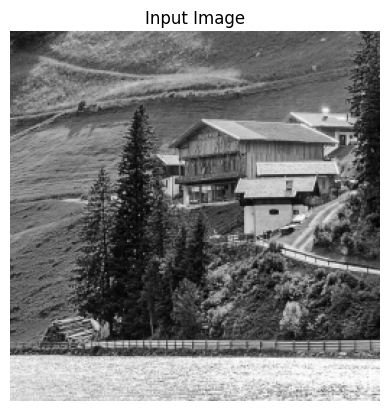

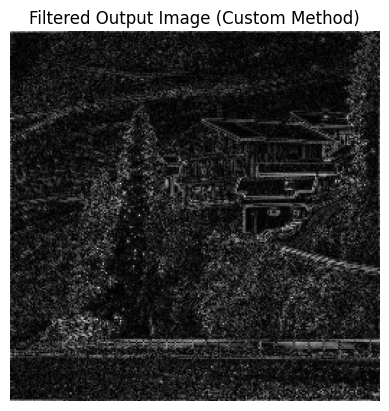

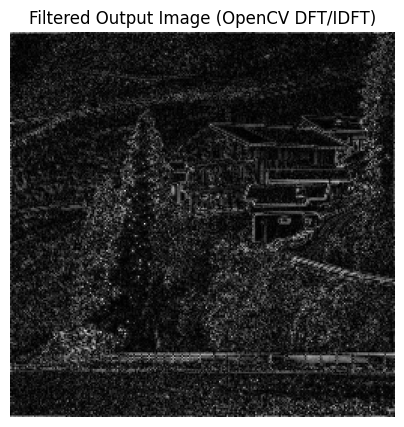

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calculate_dft_1d(data_signal):
    length = len(data_signal)
    index_array = np.arange(length)
    frequency_index = index_array[:, None]  # Create a column vector for frequency indices
    # Compute the DFT using matrix multiplication
    exponential_matrix = np.exp(-2j * np.pi * frequency_index * index_array / length)
    return np.dot(exponential_matrix, data_signal)

def calculate_dft_2d(image_array):
    # First compute DFT for each column
    column_dft = calculate_dft_1d(image_array)
    # Then compute DFT for each row
    return calculate_dft_1d(column_dft.T).T  # Transpose to handle row processing

def calculate_idft_1d(freq_data):
    length = len(freq_data)
    index_array = np.arange(length)
    frequency_index = index_array[:, None]  # Create a column vector for frequency indices
    # Compute the IDFT using matrix multiplication
    exponential_matrix = np.exp(2j * np.pi * frequency_index * index_array / length)
    return np.dot(exponential_matrix, freq_data) / length

def calculate_idft_2d(freq_data):
    # First compute IDFT for each column
    column_idft = calculate_idft_1d(freq_data)
    # Then compute IDFT for each row
    return calculate_idft_1d(column_idft.T).T  # Transpose for row processing

def shift_zero_frequency(data):
    # Center the zero frequency component in the spectrum
    return np.fft.fftshift(data)

# Functions to generate Gaussian filters
def create_low_pass_gaussian(shape, cutoff_frequency):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    std_dev = cutoff_frequency / np.sqrt(2 * np.log(2))  # Calculate standard deviation
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    return np.exp(-(distance**2) / (2 * std_dev**2))

def create_high_pass_gaussian(shape, cutoff_frequency):
    return 1 - create_low_pass_gaussian(shape, cutoff_frequency)

def create_bandpass_gaussian(shape, low_cutoff, high_cutoff):
    low_pass = create_low_pass_gaussian(shape, high_cutoff)
    high_pass = create_high_pass_gaussian(shape, low_cutoff)
    return low_pass * high_pass

# Load the grayscale input image
input_image = cv2.imread('/content/a_3_task_1_input.png', cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

# Step 1: Calculate the 2D DFT
dft_image = calculate_dft_2d(input_image)

# Step 2: Center the low frequencies
shifted_dft_image = shift_zero_frequency(dft_image)

# Step 3: Create a Gaussian bandpass filter
bandpass_filter = create_bandpass_gaussian(shifted_dft_image.shape, 100.0, 120.0)

# Step 4: Apply the bandpass filter to the DFT result
filtered_dft_image = shifted_dft_image * bandpass_filter

# Step 5: Shift back and calculate the IDFT
shifted_back_dft = shift_zero_frequency(filtered_dft_image)
output_image = calculate_idft_2d(shifted_back_dft)

# Step 6: Normalize the resulting image
output_image = np.abs(output_image)
output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min()) * 255

# Step 7: Display the filtered image
plt.imshow(output_image, cmap='gray')
plt.title('Filtered Output Image (Custom Method)')
plt.axis('off')
plt.show()

# Step 8: Validate with OpenCV's DFT and IDFT
opencv_dft = cv2.dft(np.float32(input_image), flags=cv2.DFT_COMPLEX_OUTPUT)
shifted_opencv_dft = np.fft.fftshift(opencv_dft)

# Create a bandpass filter using OpenCV
M, N = input_image.shape
u, v = np.meshgrid(np.arange(M), np.arange(N), indexing='ij')
D = np.sqrt((u - M//2)**2 + (v - N//2)**2)
low_pass_opencv = np.exp(-D**2 / (2 * (120**2)))
high_pass_opencv = 1 - np.exp(-D**2 / (2 * (100**2)))
bandpass_filter_opencv = low_pass_opencv * high_pass_opencv

# Apply the bandpass filter to OpenCV's frequency domain data
shifted_opencv_dft[:, :, 0] *= bandpass_filter_opencv  # Real part
shifted_opencv_dft[:, :, 1] *= bandpass_filter_opencv  # Imaginary part

# Inverse shift and compute IDFT using OpenCV
idft_opencv = cv2.idft(np.fft.ifftshift(shifted_opencv_dft))
magnitude_idft_opencv = cv2.magnitude(idft_opencv[:, :, 0], idft_opencv[:, :, 1])

# Display OpenCV results
plt.figure(figsize=(5, 5))
plt.imshow(magnitude_idft_opencv, cmap='gray')
plt.title('Filtered Output Image (OpenCV DFT/IDFT)')
plt.axis('off')
plt.show()


#Task 2 (7 Marks)
Perform the DFT on 2 images Im1 and Im2 of equal sizes. Use a_3_task_2_im1.png
and a_3_task_2_im2.png as inputs Im1 and Im2 respectively. Then reconstruct the
image Im1 by performing IDFT as follows:

● Im1_ver1: obtained by performing IDFT on the DFT formed by replacing the DFT
magnitude of Im1 with the DFT magnitude of Im2

● Im1_ver2: obtained by performing IDFT on the DFT formed by replacing the DFT
phase of Im1 with the DFT phase of Im2

Which one of these two reconstructed versions are closer to the original image Im1 and
why?

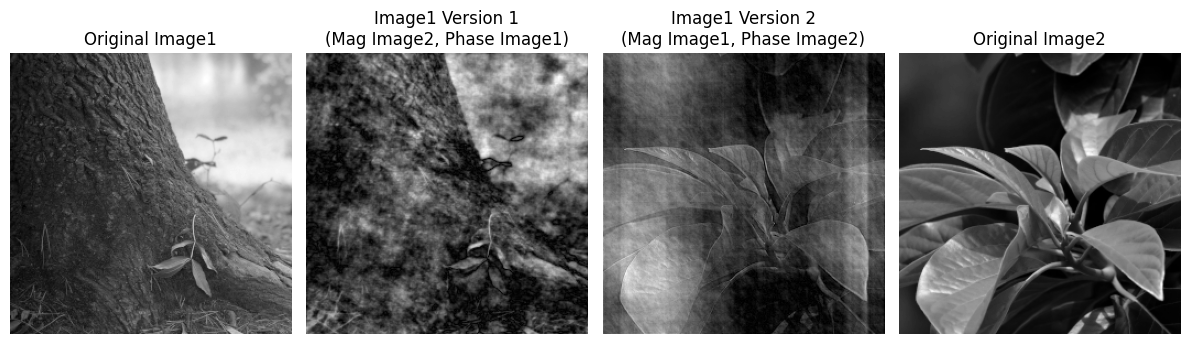

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to compute the 2D Discrete Fourier Transform (DFT) of an image
def compute_dft(image):
    return np.fft.fft2(image)

# Function to compute the inverse 2D Discrete Fourier Transform (IDFT) from frequency domain
def compute_idft(freq_image):
    return np.fft.ifft2(freq_image)

# Load images and convert to grayscale arrays
image1_path = '/content/a_3_task_2_im1.png'
image2_path = '/content/a_3_task_2_im2.png'

image1 = np.array(Image.open(image1_path).convert('L'))
image2 = np.array(Image.open(image2_path).convert('L'))

# Perform DFT on both images
dft_image1 = compute_dft(image1)
dft_image2 = compute_dft(image2)

# Extract magnitude and phase from both DFT results
magnitude_image1, phase_image1 = np.abs(dft_image1), np.angle(dft_image1)
magnitude_image2, phase_image2 = np.abs(dft_image2), np.angle(dft_image2)

# Reconstruction 1: Use magnitude from image2 and phase from image1
dft_image1_version1 = magnitude_image2 * np.exp(1j * phase_image1)
image1_version1 = np.abs(compute_idft(dft_image1_version1))

# Reconstruction 2: Use magnitude from image1 and phase from image2
dft_image1_version2 = magnitude_image1 * np.exp(1j * phase_image2)
image1_version2 = np.abs(compute_idft(dft_image1_version2))

# Plot and compare the results
plt.figure(figsize=(12, 6))

# Display original image1
plt.subplot(1, 4, 1)
plt.imshow(image1, cmap='gray')
plt.title('Original Image1')
plt.axis('off')

# Display version 1: Magnitude of Image2 + Phase of Image1
plt.subplot(1, 4, 2)
plt.imshow(image1_version1, cmap='gray')
plt.title('Image1 Version 1\n(Mag Image2, Phase Image1)')
plt.axis('off')

# Display version 2: Magnitude of Image1 + Phase of Image2
plt.subplot(1, 4, 3)
plt.imshow(image1_version2, cmap='gray')
plt.title('Image1 Version 2\n(Mag Image1, Phase Image2)')
plt.axis('off')

# Display original image2 for comparison
plt.subplot(1, 4, 4)
plt.imshow(image2, cmap='gray')
plt.title('Original Image2')
plt.axis('off')

plt.tight_layout()
plt.show()


The image referred to as Im1_ver2, which utilizes the phase information from Im2, is likely to resemble the original image Im1 more closely. This is because the phase in a Fourier transform captures finer spatial details, whereas the magnitude mainly conveys intensity or energy. As a result, modifying the phase significantly influences the visual characteristics of the image.

#Task 3 (6 Marks)

● (Aliasing in the frequency domain) - perform DFT on an image and show its
magnitude spectrum. Now, subsample the image by setting every alternate pixel to 0 along both horizontal and vertical directions, and show the magnitude
spectrum of the resulting subsampled image. What difference do you observe in
the two magnitude spectra? Please explain your observation. Use
a_3_task_3_input_a.png as input. (3 marks)

● (Aliasing in the spatial domain) - perform DFT on an image. Now subsample the
DFT along the horizontal axis by setting every 3rd DFT coefficient to 0 along this
axis. Then perform IDFT using the subsampled DFT. What effect do you observe
on the spatial signal? Can you explain this effect? Use a_3_task_3_input_b.png
as input. (3 marks)

(In this question, it is fine to use cv2.dft and cv2.idft directly)

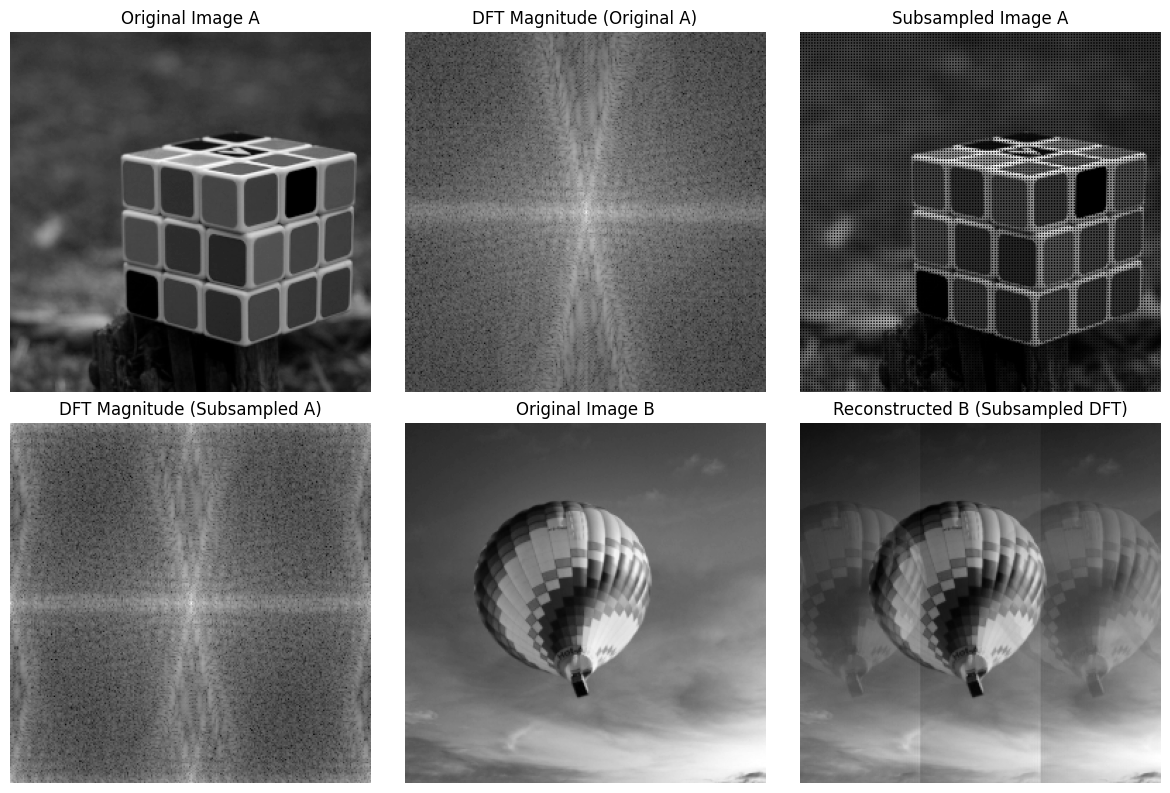

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Function to compute the DFT and generate the magnitude spectrum
def compute_dft_magnitude(image):
    dft_result = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    shifted_dft = np.fft.fftshift(dft_result)  # Shift low frequencies to the center
    magnitude_spectrum = 20 * np.log(cv2.magnitude(shifted_dft[:, :, 0], shifted_dft[:, :, 1]) + 1)
    return magnitude_spectrum, shifted_dft

# Function to apply the inverse DFT to return the image back to the spatial domain
def inverse_dft(shifted_dft):
    unshifted_dft = np.fft.ifftshift(shifted_dft)
    spatial_image = cv2.idft(unshifted_dft)
    result_image = cv2.magnitude(spatial_image[:, :, 0], spatial_image[:, :, 1])
    return result_image

# Part 1: Subsampling the image in the spatial domain
def apply_spatial_subsampling(image):
    subsampled = image.copy()
    subsampled[::2, ::2] = 0  # Remove every alternate pixel along both axes
    return subsampled

# Part 2: Subsampling the DFT by modifying the horizontal frequencies
def apply_dft_horizontal_subsampling(dft_image):
    dft_image[:, ::3] = 0  # Set every third horizontal frequency component to zero
    return dft_image

# Function to load an image and convert it to grayscale
def load_grayscale_image(image_path):
    return np.array(Image.open(image_path).convert('L'))

# Main function to execute both tasks
def process_images_for_task3(image_a_path, image_b_path):
    # Load images
    image_a = load_grayscale_image(image_a_path)
    image_b = load_grayscale_image(image_b_path)

    # Part 1: Compute DFT and magnitude for original and subsampled versions of image A
    original_magnitude, original_dft = compute_dft_magnitude(image_a)
    subsampled_a = apply_spatial_subsampling(image_a)
    subsampled_magnitude, _ = compute_dft_magnitude(subsampled_a)

    # Part 2: Perform DFT subsampling along horizontal axis for image B
    _, dft_image_b = compute_dft_magnitude(image_b)
    subsampled_dft_b = apply_dft_horizontal_subsampling(dft_image_b)
    reconstructed_b = inverse_dft(subsampled_dft_b)

    # Visualization of results
    plt.figure(figsize=(12, 8))

    # Original Image A and its DFT magnitude spectrum
    plt.subplot(2, 3, 1)
    plt.imshow(image_a, cmap='gray')
    plt.title('Original Image A')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(original_magnitude, cmap='gray')
    plt.title('DFT Magnitude (Original A)')
    plt.axis('off')

    # Subsampled Image A and its DFT magnitude spectrum
    plt.subplot(2, 3, 3)
    plt.imshow(subsampled_a, cmap='gray')
    plt.title('Subsampled Image A')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(subsampled_magnitude, cmap='gray')
    plt.title('DFT Magnitude (Subsampled A)')
    plt.axis('off')

    # Original Image B and reconstructed Image B after DFT subsampling
    plt.subplot(2, 3, 5)
    plt.imshow(image_b, cmap='gray')
    plt.title('Original Image B')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(np.abs(reconstructed_b), cmap='gray')
    plt.title('Reconstructed B (Subsampled DFT)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Image paths for Task 3
image_a_path = '/content/a_3_task_3_input_a.png'
image_b_path = '/content/a_3_task_3_input_b.png'

# Process images and display results for Task 3
process_images_for_task3(image_a_path, image_b_path)


**Aliasing in the Frequency Domain (Top Row)**
The original image (Image A) and its corresponding magnitude spectrum exhibit a balanced frequency distribution. However, after subsampling the image by setting every alternate pixel to zero, the magnitude spectrum reveals a concentration of high-frequency components. This effect is attributed to aliasing, which occurs when subsampling introduces artifacts and overlaps in the frequency domain.

**Aliasing in the Spatial Domain (Bottom Row)**
In the case of Image B, setting every third DFT coefficient to zero along the horizontal axis results in a reconstructed image that displays significant artifacts and distortions. These distortions stem from the removal of essential frequency information when certain coefficients are zeroed out, leading to alterations in the spatial details.


In the frequency domain, subsampling the image results in aliasing because higher frequencies are effectively folded back into lower frequencies, leading to enhanced noise or artifacts. In the spatial domain, the omission of specific DFT coefficients disrupts the original frequency makeup of the image, causing noticeable degradation or blurring in the reconstructed spatial signal.